In [1]:
%matplotlib notebook
import logging
logging.basicConfig()
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [2]:
import unittest
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from deepART import ProbART, base, dataset, deepART
from sklearn.datasets import make_moons
from concurrent.futures import ThreadPoolExecutor

/usr/local/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### Generate dataset

In [3]:
#sample_data = dataset.Clusters2d_overlap(nclusters=6,overlap=0.1,spread=0.1, data_range=[0, 10000])
#sample_data = dataset.TwoSpirals(100, noise=1)
np.random.seed(0)
X, y = make_moons(n_samples=200, noise=0.05)
#scale data
X[:,0] = X[:,0]-np.min(X[:,0])
X[:,1] = X[:,1]-np.min(X[:,1])
sample_data = dataset.Dataset(X)

#npoints = 200
#sample_data = dataset.TwoSpirals(npoints, noise=30)

<IPython.core.display.Javascript object>


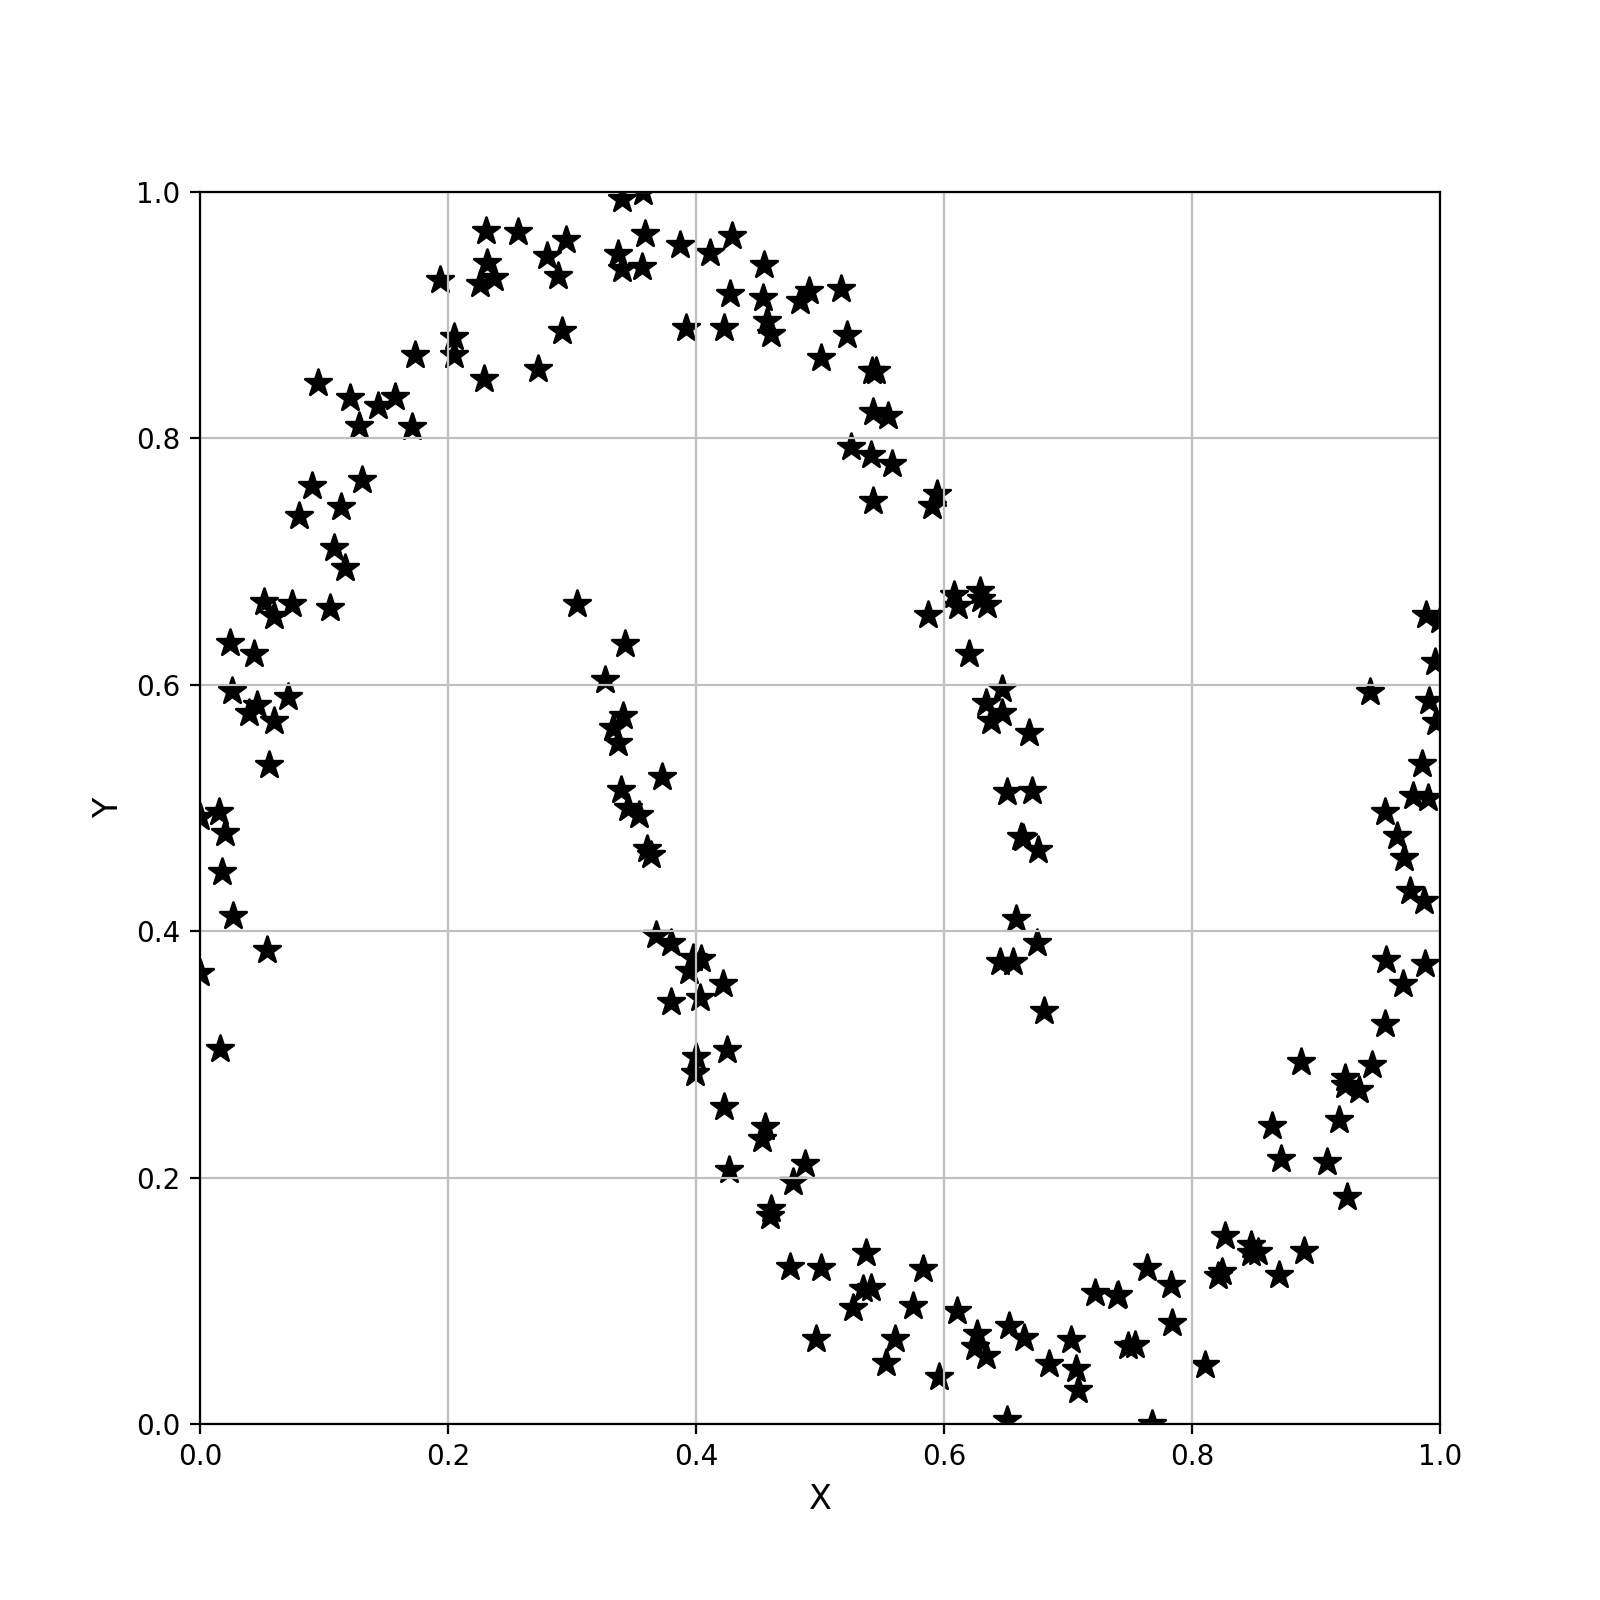

In [4]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

ax.set_xlabel("X",fontsize=12)
ax.set_ylabel("Y",fontsize=12)
ax.grid(True,linestyle='-',color='0.75')
# scatter with colormap mapping
ax.scatter(sample_data.data_normalized[...,0],sample_data.data_normalized[...,1],s=100,c='k',marker='*')
ax.axis((0, 1, 0, 1))
plt.show()
#fig.savefig('data_raw.png', bbox_inches='tight')

In [5]:
convergence = 10
neurons = 50
rho_0 = 0.35088
rho_1 = 0.2088
rho_2 = 0.2088
beta = 0.75
alpha = 0.1
camRule_0 = {'p':2,'q':3}
camRule_1 = {'p':2,'q':2}
camRule_2 = {'p':2,'q':1}
main_executor = ThreadPoolExecutor(max_workers=8)
network = deepART.Sequential()
network.add(ProbART( 2, neurons, rho=rho_0,alpha=alpha, beta=beta,comp=True,camRule=camRule_0)) # add first probart layer
network.add(ProbART( 2, neurons, rho=rho_1,alpha=alpha, beta=beta,comp=True,camRule=camRule_1)) # add second probart layer
network.add(ProbART( 2, neurons, rho=rho_2,alpha=alpha, beta=beta,comp=True,camRule=camRule_2)) 
print("Start testing...")
predictions = network.fit_predict(epochs=1, x=sample_data.data_normalized, convergence=convergence, shuffle=False, threading=main_executor)
pred_0 = predictions['SubModel_0'] # first unit
pred_1 = predictions['SubModel_1'] # second unit
pred_2 = predictions['SubModel_2'] # third unit

Start testing...
Epoch: 0
Epoch: 0
Epoch: 0


In [6]:
pred_0[0]

[(0, 0.6913963106427242), (1, 0.15087103802704638), (2, 0.14053502647268318)]

In [7]:
pred_0[0]

[(0, 0.6913963106427242), (1, 0.15087103802704638), (2, 0.14053502647268318)]

In [8]:
res = [score for _, score in pred_2[0]]
idxMax = np.argmax(res)
k, _ = pred_2[0][idxMax]
k

0

## Generate contour plot for cluster membership


In [9]:
def unpack_results(pred,target):
    #unpack result tuples
    pred_k = []
    scores = []
    data_contour = np.empty((0,2),dtype=np.float32)
    for n, results in enumerate(pred):
        for res_tuple in results:
            k, score = res_tuple
            pred_k.append(k)

            if k == target:
                data_contour = np.vstack((data_contour, sample_data.data_normalized[n]))
                scores.append(score)
    return data_contour, scores, pred_k

In [10]:
def plot_countour(fig,data_contour, scores, sub_index, nplots=(3,2)):
    ax = fig.add_subplot(nplots[0],nplots[1],sub_index)

    ax.set_title("Clustering Results ",fontsize=14)
    ax.set_xlabel("X",fontsize=12)
    ax.set_ylabel("Y",fontsize=12)
    ax.grid(True,linestyle='-',color='0.75')
    # scatter with colormap mapping to predicted class
    ax.tricontour(data_contour[...,0], data_contour[...,1], scores, 14, linewidths=0, colors='k')
    cntr2 = ax.tricontourf(data_contour[...,0], data_contour[...,1], scores, 14, cmap="RdBu_r",)

    fig.colorbar(cntr2, ax=ax)
    ax.plot(data_contour[...,0], data_contour[...,1], 'ko', ms=0.5)
    ax.axis((0, 1, 0, 1))
    ax.set_title('Cluster {}'.format(int(sub_index-1)))

    plt.subplots_adjust(hspace=0.5)
    plt.show()
    #fig.savefig('data_clustered.png', bbox_inches='tight')

In [11]:
pred_view = pred_2

In [12]:

#get unique topics
_, _, ks = unpack_results(pred_view,target=0)
unique_ks = set(ks)
print(unique_ks)

{0, 1}


<IPython.core.display.Javascript object>


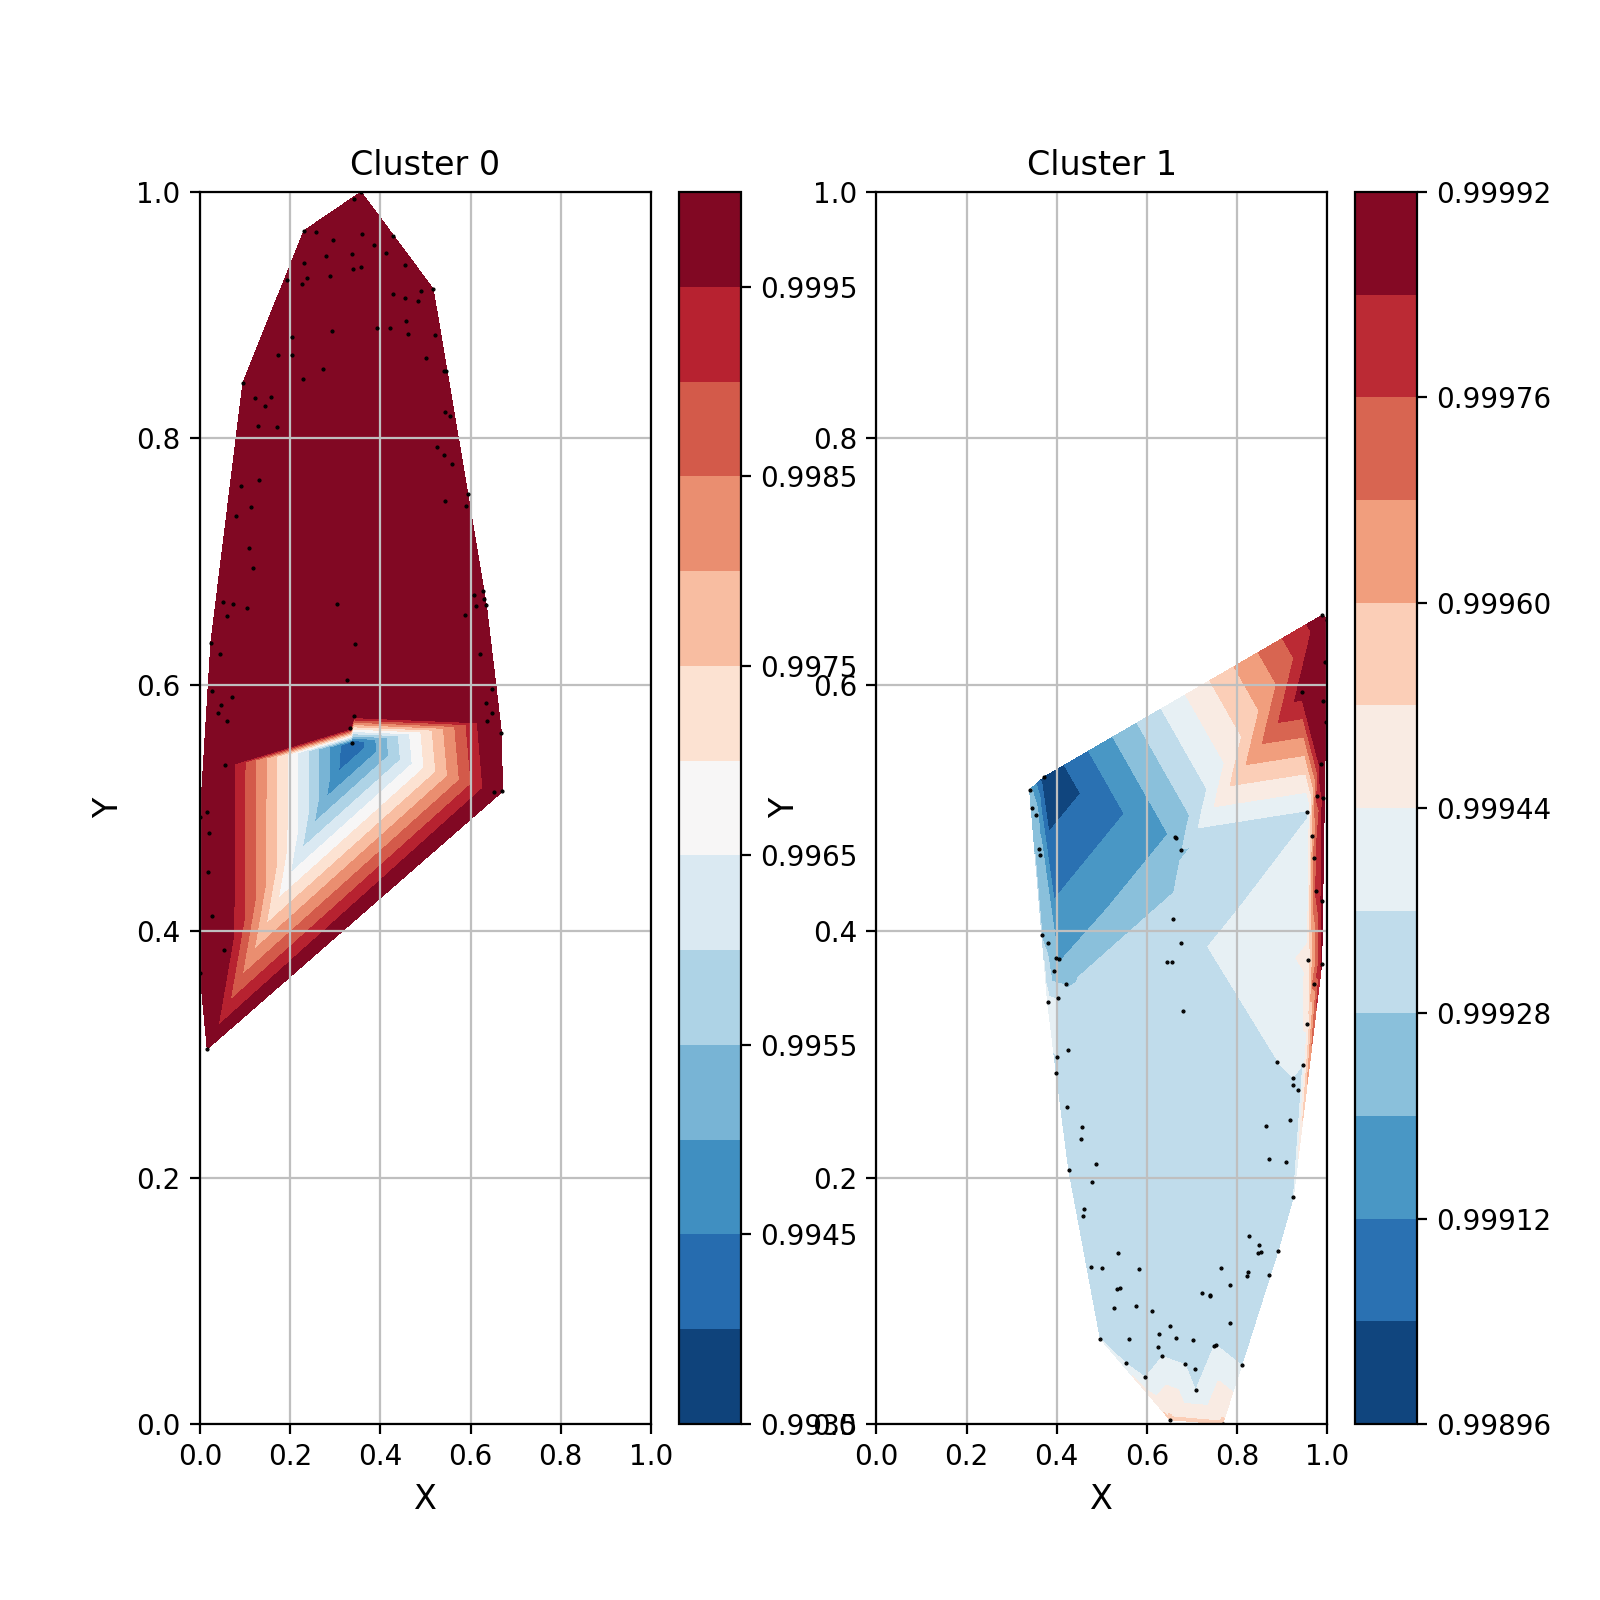

In [13]:
#plot out clusters memebership
fig = plt.figure(figsize=(8,8))
nplots = (int(np.ceil(len(unique_ks)/2)), 2)
for i in range(len(unique_ks)):
    data_contour, scores, _ = unpack_results(pred_view,target=i)
    plot_countour(fig, data_contour,scores, sub_index=i+1,nplots=nplots)
# plt.savefig("deepart_contour_3.png")

## Cluster segmentation by argmax

In [14]:
def get_clusters(pred):
    ks = []
    for result in pred:
        #unpack prediction
        res = [score for _, score in result]
        idxMax = np.argmax(res)
        k, _ = result[idxMax]
        ks.append(k)
    return ks

In [15]:
ks = get_clusters(pred_view)

<IPython.core.display.Javascript object>


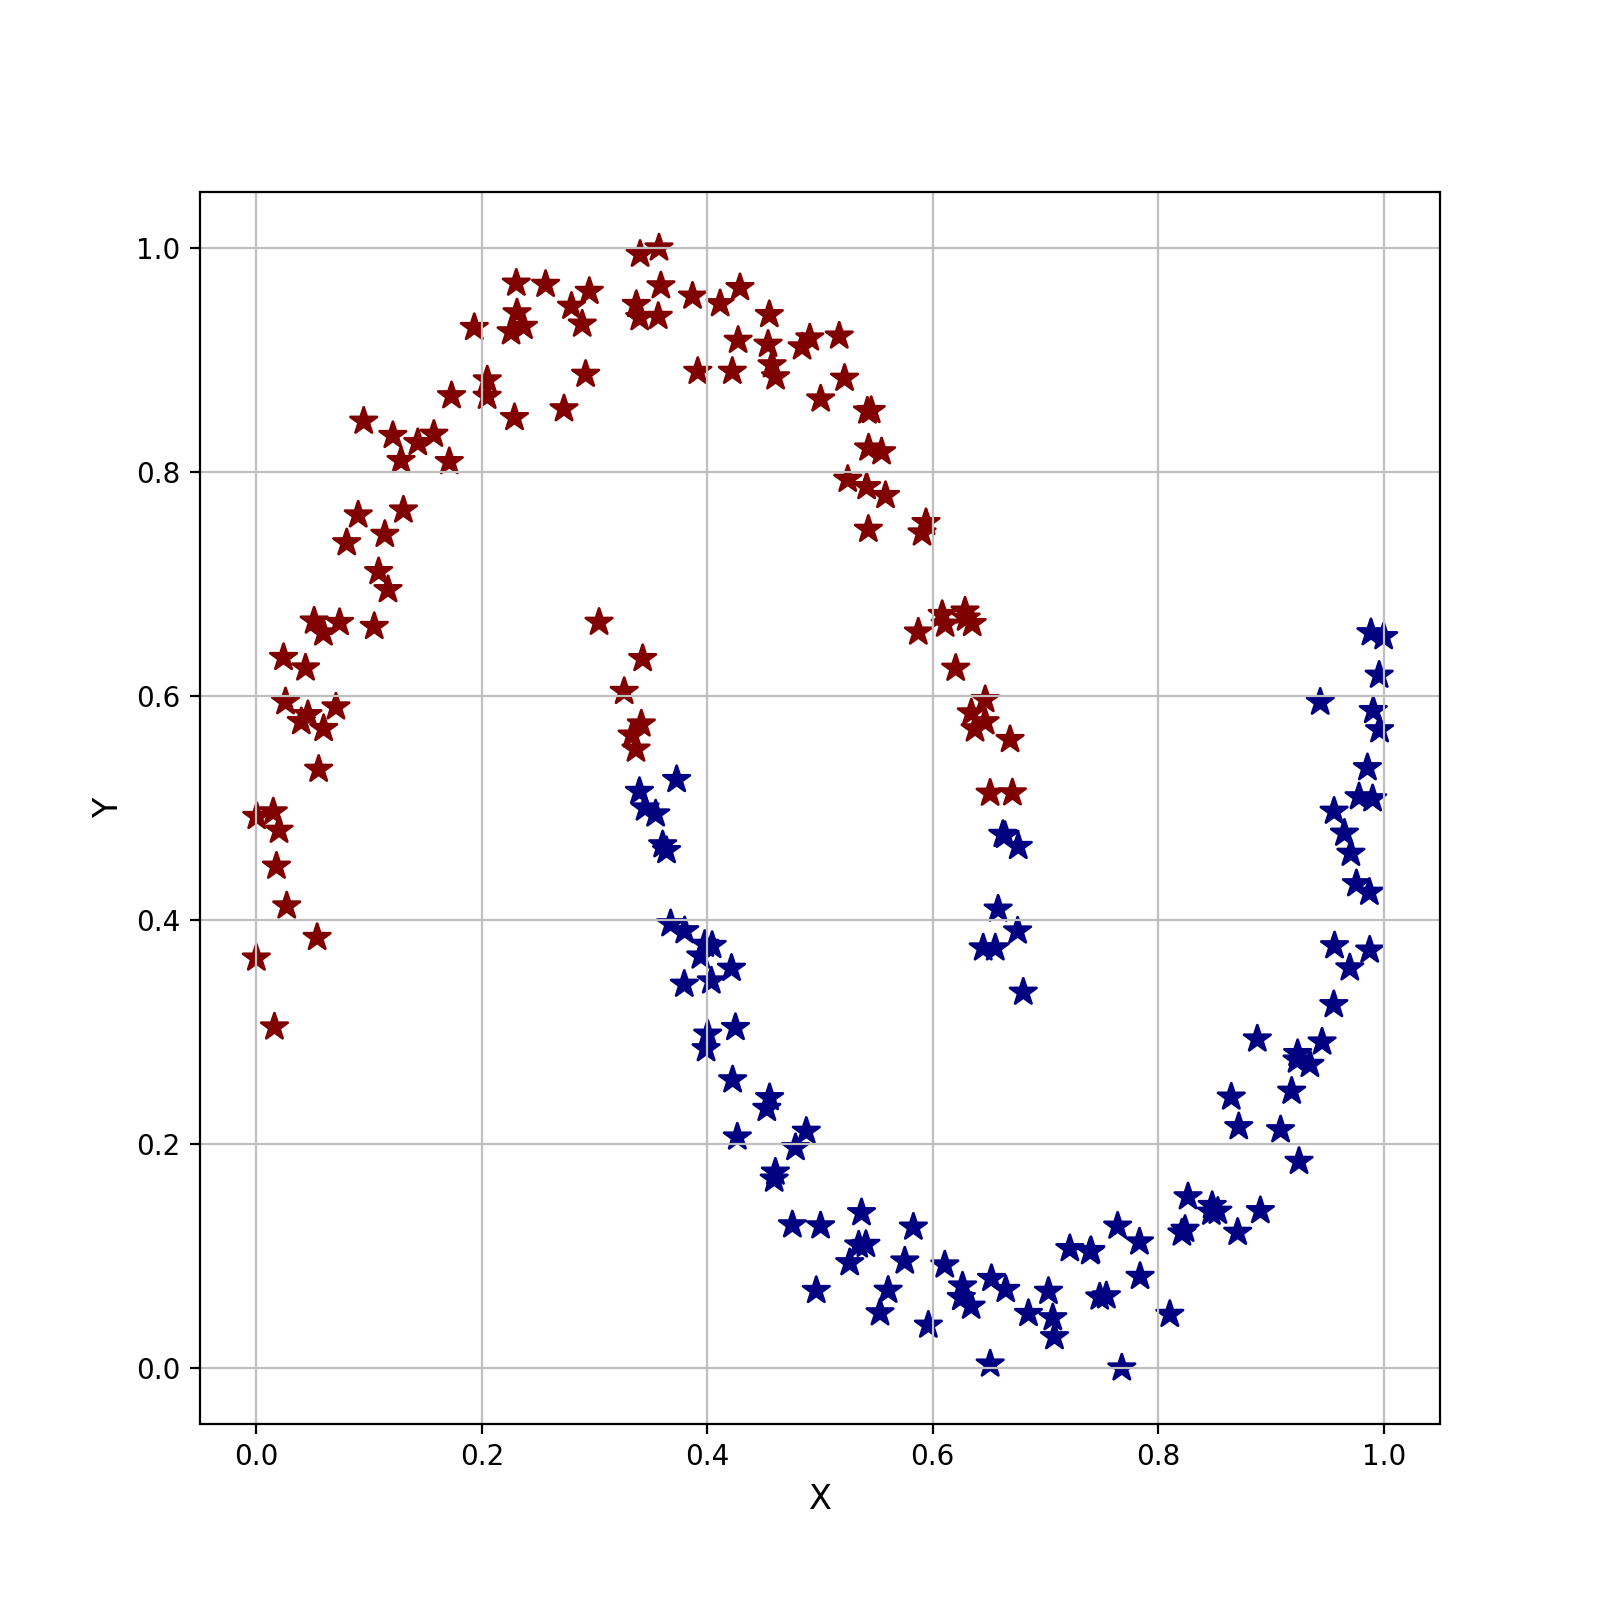

In [16]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

# ax.set_title("Clustering Results ",fontsize=14)
ax.set_xlabel("X",fontsize=12)
ax.set_ylabel("Y",fontsize=12)
# ax.set_ylabel("Z",fontsize=12)
ax.grid(True,linestyle='-',color='0.75')
# scatter with colormap mapping to predicted class
color = [c+1 for c in ks]
ax.scatter(sample_data.data_normalized[...,0],sample_data.data_normalized[...,1],s=100,c=color, marker = '*', cmap = cm.jet_r );

plt.show()
# plt.savefig("deepart_correct_3")

In [17]:
dic = {1: 0,2: 1}
color = list(map(lambda i: dic[i], color))

from sklearn.metrics import silhouette_score, davies_bouldin_score, precision_score, recall_score, f1_score, accuracy_score, normalized_mutual_info_score

def obtain_metrics(x, y_true, y_pred):
    results = dict({})
    results["silhouette_score"] = silhouette_score(x, y_pred)
    results["davies_bouldin_score"] = davies_bouldin_score(x, y_pred)
    results["normalized_mutual_info_score"] = normalized_mutual_info_score(y_true, y_pred)
    results["precision_score"] = precision_score(y_true, y_pred)
    results["recall_score"] = recall_score(y_true, y_pred)
    results["f1_score"] = f1_score(y_true, y_pred)
    results["accuracy_score"] = accuracy_score(y_true, y_pred)
    return results

obtain_metrics(sample_data.data_normalized, y, color)

{'silhouette_score': 0.46613744,
 'davies_bouldin_score': 0.8493301085869464,
 'normalized_mutual_info_score': 0.634991003019842,
 'precision_score': 0.9215686274509803,
 'recall_score': 0.94,
 'f1_score': 0.9306930693069307,
 'accuracy_score': 0.93}